# Insight Data Challenge #2
### by Pedro de Bruin

## Goal
Employee turn-over is a very costly problem for companies. The cost of replacing an employee
if often larger than 100K USD, taking into account the time spent to interview and find a
replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

It is only natural then that data science has started being applied to this area. Understanding
why and when employees are most likely to leave can lead to actions to improve employee
retention as well as planning new hiring in advance. This application of DS is sometimes called
people analytics or people data science (if you see a job title: people data scientist, this is your
job).

In this challenge, you have a data set with info about the employees and have to predict when
employees are going to quit by understanding the main drivers of employee churn.

## Challenge Description
We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers.
Specifically, you should:
- Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
**You should create a table with 3 columns: day, employee_headcount, company_id.**
- What are the main factors that drive employee churn? Do they make sense? Explain your
findings. 
- If you could add to this data set just one variable that could help explain employee churn,
what would that be?

## Data
We have 1 table downloadable by clicking [here](https://drive.google.com/uc?export=download&id=0B5G7QmUBc4IROGFHTHNyeVRLaG8).
The table is:

"employee_retention" - comprehensive information about employees.

Columns:
- employee_id : id of the employee. Unique by employee per company
- company_id : company id.
- dept : employee dept
- seniority : number of yrs of work experience when hired
- salary: avg yearly salary of the employee during her tenure within the company
- join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
- quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

## Let's begin with a simple EDA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/home/pedro/Downloads/employee_retention_data.csv')

In [3]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


We see several things right away:
    - The quit_date column has over 10000 missing values (24702-13510)
    - The join_date and quit_date columns are timestamps with day-level granularity
    - employee_id is a float for some reason, and includes a single decimal place
    - Salaries appear to be rounded off to the nearest $1000 (though this should be double-checked)

## Data pre-processing

### 1. We can see employee_id always has '.0' for decimals, so it can be converted to an integer without loss of information:

In [5]:
print(sum(df['employee_id'] != df['employee_id'].astype(int)))

0


In [6]:
df['employee_id'] = df['employee_id'].astype(int)

### 2. Let's add a categorical column to identify employees still employed by each company:

In [7]:
df['still_employed'] = df['quit_date'].isna().astype(int)

Let's plot that fraction:

[Text(0, 0, 'Quit'), Text(0, 0, 'Employed')]

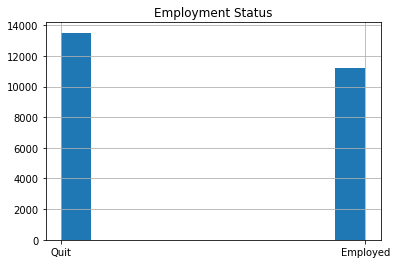

In [8]:
fig, ax = plt.subplots()
ax = df['still_employed'].hist()
ax.set_title('Employment Status')
ax.set_xticks([0,1])
ax.set_xticklabels(['Quit', 'Employed'], ha='center')

So the classes are mostly balanced, at least when averaged across all companies

### 3. Add a days_employed column

First let's convert the join_date and quit_date columns to datetime dtype:

In [9]:
from datetime import datetime

In [10]:
df['join_date'] =  pd.to_datetime(df['join_date'])
df['quit_date'] =  pd.to_datetime(df['quit_date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
employee_id       24702 non-null int64
company_id        24702 non-null int64
dept              24702 non-null object
seniority         24702 non-null int64
salary            24702 non-null float64
join_date         24702 non-null datetime64[ns]
quit_date         13510 non-null datetime64[ns]
still_employed    24702 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 1.5+ MB


In [12]:
df['days_employed'] = (df['quit_date'] - df['join_date']).dt.days

## Let's have a look at the distribution of days employees remain employed:

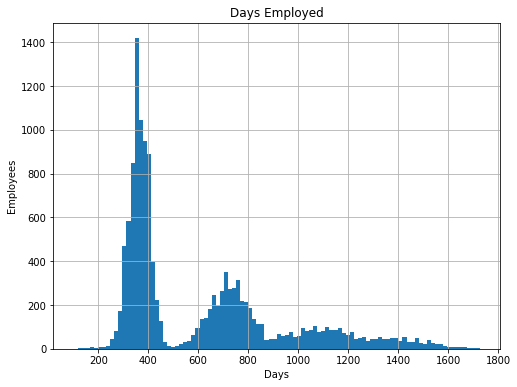

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax = df['days_employed'].hist(bins=100)
ax.set_title('Days Employed');
ax.set_xlabel('Days');
ax.set_ylabel('Employees');

Look at that! The distribution is at least bi-modal, with a 3rd (and perhaps 4th) highly loyal employee region in the tail.

### Let's also check how days employed varies across companies and departments:

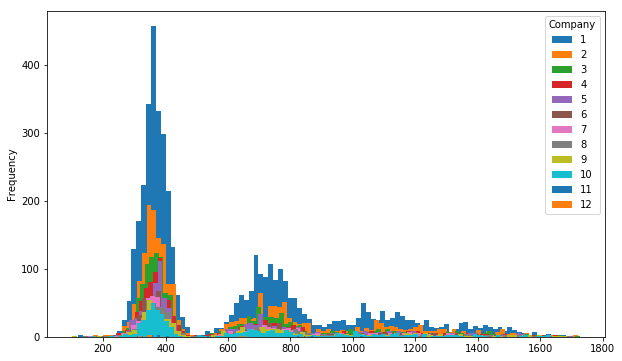

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
for name, group in df.groupby('company_id'):
    group['days_employed'].plot(kind='hist', bins=100, label=name)

ax.legend(title='Company')
plt.show()

Since the companies have different sizes, let's plot it normalized so that we can compare the churn rates better. We ignore 2, 11 and 12 due to very small size.

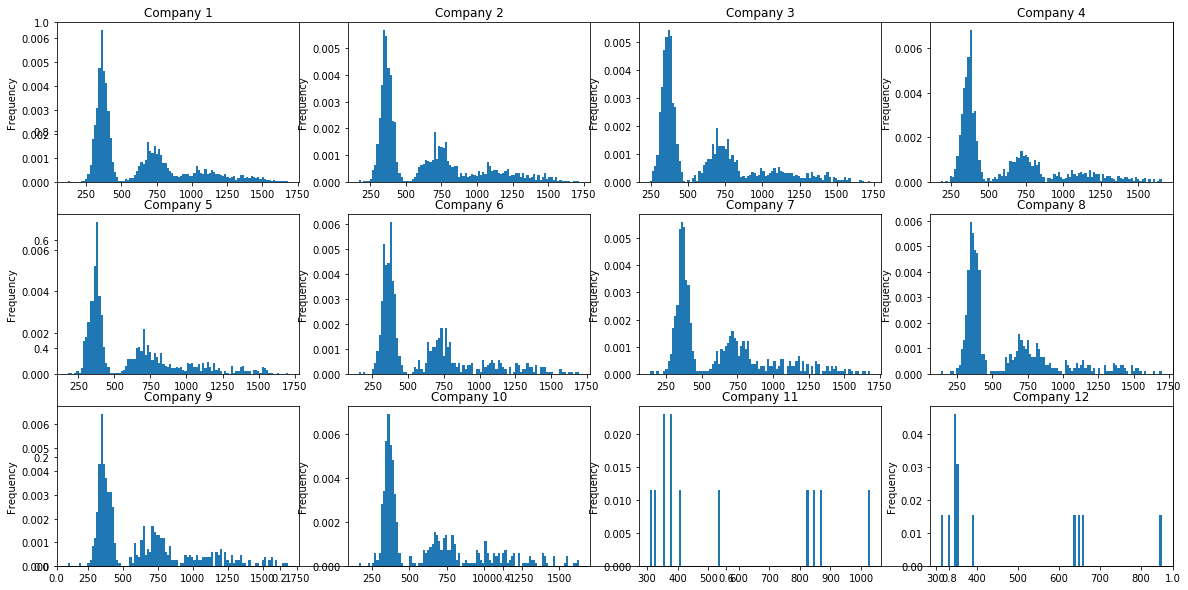

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
for i, (name, group) in enumerate(df.groupby('company_id')):
    i+=1
    #if name==2 or name>10: continue
    ax = fig.add_subplot(3,4,i)
    group['days_employed'].plot(kind='hist', bins=100, label=name, density=True)
    ax.set_title('Company {}'.format(name))
    
plt.show()

**Thus we see companies 1 through 10 have similar employment duration distributions. Companies 11 and 12 have too few employees to confirm the trend but are nevertheless compatible with the distribution seen for the others.**

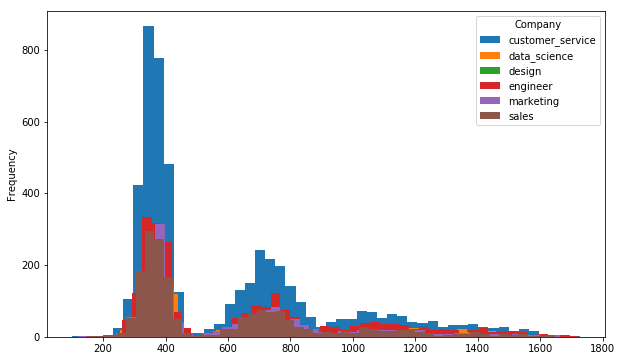

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
for name, group in df.groupby('dept'):
    group['days_employed'].plot(kind='hist', bins=50, label=name)

ax.legend(title='Company')
plt.show()

Thus we don't see a strong trend by department

## Regression on expected number of days employed

In [17]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_employed,days_employed
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,585.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,340.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,1,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,389.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,1040.0


In [20]:
df_quit = df.loc[df['days_employed'].notna(), :]

Let's drop rows where company_id is not specified

In [21]:
df_quit = df_quit.loc[df_quit['company_id'].notna(), :]

In [22]:
temp_x = pd.get_dummies(df_quit['dept'])
df_quit = pd.concat([df_quit, temp_x], axis=1)

In [23]:
df_quit.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_employed,days_employed,customer_service,data_science,design,engineer,marketing,sales
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,585.0,1,0,0,0,0,0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,340.0,0,0,0,0,1,0
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,389.0,1,0,0,0,0,0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,1040.0,0,1,0,0,0,0
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,0,578.0,0,1,0,0,0,0


## Engineer features

- Salary difference from dept mean

In [24]:
salary_means = df.groupby('dept')['salary'].mean()

In [25]:
print(salary_means)

dept
customer_service     82245.424837
data_science        206885.893417
design              137460.869565
engineer            205544.548016
marketing           135598.042311
sales               135912.358134
Name: salary, dtype: float64


In [26]:
df_quit['salary_dev'] = df_quit['salary']
for d in salary_means.index:
    df_quit.loc[df_quit['dept'] == d, 'salary_dev'] = df_quit.loc[df['dept'] == d, 'salary_dev'].apply(lambda x: x - salary_means[d])

In [27]:
clf = StandardScaler()
df_quit['salary_dev'] = clf.fit_transform(df_quit.loc[:, ['salary_dev']])

In [28]:
df_quit.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_employed,days_employed,customer_service,data_science,design,engineer,marketing,sales,salary_dev
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,585.0,1,0,0,0,0,0,0.144985
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,340.0,0,0,0,0,1,0,0.896949
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,389.0,1,0,0,0,0,0,0.625977
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,1040.0,0,1,0,0,0,0,1.298617
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,0,578.0,0,1,0,0,0,0,-0.754849


In [54]:
cols_to_use = ['company_id', 'seniority', 'salary', 'salary_dev', 
               'customer_service', 'data_science', 'design', 'engineer', 'marketing', 'sales']

In [55]:
X_train, X_test, y_train, y_test = \
train_test_split(df_quit[cols_to_use], df_quit['days_employed'], test_size=0.2)

In [56]:
X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, test_size=0.125)

In [57]:
cols_to_use = ['company_id', 'seniority', 'salary', 
               'customer_service', 'data_science', 'design', 
               'engineer', 'marketing', 'sales']

### Do a regression!

In [58]:
reg = RandomForestRegressor(max_depth=4, n_estimators=300)
#reg = linear_model.Ridge (alpha = .5)

In [59]:
reg.fit(X_train, y_train)

ValueError: could not convert string to float: 'sales'

### Evaluating performance!

In [47]:
y_val_pred = reg.predict(X_val)

In [48]:
mean_absolute_error(y_val, y_val_pred)

272.3588011786359

In [49]:
r2_score(y_val, y_val_pred)

0.03534432647399843

In [ ]:
y_test_pred = reg.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_test_pred)

In [ ]:
r2_score(y_test, y_test_pred)

## Forecasting Churn

In [ ]:
df['join_date'].sort_values().head()

In [ ]:
df['quit_date'].sort_values(ascending=False).head()

In [ ]:
churn_df = pd.date_range(start='1/24/2011', end='12/09/2015', freq='d')

In [ ]:
churn_df['company_id']

## Final forecast Dataframe

In [ ]:
pred_df = pd.DataFrame(columns = ['days', 'employee_headcount', 'company_id'])

In [ ]:
pred_df['company_id'] = df['company_id']
pred_df['employee_headcount'] = df.groupby('company_id')['join_date'].count() - df.groupby('company_id')['quit_date'].count()

In [ ]:
pred_df['employee_headcount'].sort_values(ascending=False).head(10)

In [ ]:
df['join_date'].sort_values().head()

In [ ]:
df['quit_date'].sort_values(ascending=False).head()

In [ ]:
pred_df.info()

In [ ]:
pred_df.index = pd.date_range(start='1/24/2011', end='12/09/2015', freq='d')

## Forecasting churn